## Quantium Virtual Internship - Retail Strategy and Analytics - Task 1

This Jupyter notebook follows a solution scaffold converted from R for Python for the task provided.

In [46]:
import pandas as pd

In [47]:
# Set up the dataframes
purchase_behaviour_df = pd.read_csv("C:/Users/Jacqu/OneDrive/Documents/Employment/Quantium/QuantiumVEP/Task1/QVI_purchase_behaviour.csv")
transaction_data_df = pd.read_excel("C:/Users/Jacqu/OneDrive/Documents/Employment/Quantium/QuantiumVEP/Task1/QVI_transaction_data.xlsx")

### Exploratory Data Analysis

Let's first examine the transaction data.

In [48]:
# Check if the columns that are expected to be numeric are in numeric form
print("Purchase Behvaiour Datatypes: \n", purchase_behaviour_df.dtypes, "\n")
print("Transaction Data Datatypes: \n", transaction_data_df.dtypes)

Purchase Behvaiour Datatypes: 
 LYLTY_CARD_NBR       int64
LIFESTAGE           object
PREMIUM_CUSTOMER    object
dtype: object 

Transaction Data Datatypes: 
 DATE                int64
STORE_NBR           int64
LYLTY_CARD_NBR      int64
TXN_ID              int64
PROD_NBR            int64
PROD_NAME          object
PROD_QTY            int64
TOT_SALES         float64
dtype: object


We know that if there is mixed datatypes, it will get stored as an object dtype. Thus, the numeric columns are all satisfactory, since they all int64 and float64 dtypes. it can be seen that the date data is stored in integer format, so let's convert it to date time. It is known that Excel dates begin on 30 Dec 1899, so we will use that as the origin.

In [49]:
transaction_data_df["DATE"] = pd.to_datetime(transaction_data_df["DATE"], origin="1899-12-30", unit="D")

# Check if the DATE column is now in the correct format:
transaction_data_df["DATE"].head()

0   2019-05-19
1   2019-05-16
2   2019-05-16
3   2018-08-20
4   2019-05-17
Name: DATE, dtype: datetime64[ns]

Okay so it is in the correct format. Next, let's see a summary of the PROD_NAME column.

In [50]:
transaction_data_df["PROD_NAME"]

0         Old El Paso Salsa   Dip Tomato Mild 300g
1         Smiths Crinkle Chips Salt & Vinegar 330g
2            Grain Waves         Sweet Chilli 210g
3          Doritos Corn Chip Mexican Jalapeno 150g
4         Smiths Crinkle Chips Salt & Vinegar 330g
                            ...                   
264831        Thins Potato Chips  Hot & Spicy 175g
264832    Smiths Thinly       Swt Chli&S/Cream175G
264833              Pringles SourCream  Onion 134g
264834            Dorito Corn Chp     Supreme 380g
264835            Dorito Corn Chp     Supreme 380g
Name: PROD_NAME, Length: 264836, dtype: object

So this definitely looks like we are looking at chips. Let's examine each word in PROD_NAME to see if there are any incorrect entries, such as products that are not chips.

In [51]:
product_words = transaction_data_df["PROD_NAME"].str.split(expand=True).stack().reset_index(drop=True)
product_words_df = pd.DataFrame({"words": product_words})
product_words_df.head()

,words
0,Old
1,El
2,Paso
3,Salsa
4,Dip


As we are only interested in words that will tell us if the product is chips or not, let's remove all words with digits and special characters such as '&' from our set of product words.

In [52]:
import re
product_words_df = product_words_df[~product_words_df["words"].str.contains(r'\d|[^\w\s]', regex=True)]
product_words_df.head()

,words
0,Old
1,El
2,Paso
3,Salsa
4,Dip


Let's look at the most common words by counting the number of times a word appears and sorting the dataframe 
by this frequency in order of highest to lowest frequency.

In [53]:
word_counts = product_words_df.groupby(['words']).size().reset_index(name='Count').sort_values(['Count'], ascending=False)
word_counts.head(10)

,words,Count
28,Chips,49770
70,Kettle,41288
126,Smiths,28860
117,Salt,27976
18,Cheese,27890
106,Pringles,25102
52,Doritos,24962
41,Crinkle,23960
38,Corn,22063
92,Original,21560


There are also salsa products in the dataset but we are only interested in the chips category, so let's remove these.

In [54]:
# Convert PROD_NAME column to lowercase
transaction_data_df["PROD_NAME"] = transaction_data_df["PROD_NAME"].str.lower()

# Remove salsa products
transaction_data_df= transaction_data_df[~transaction_data_df["PROD_NAME"].str.contains("salsa")]

Next, we can use 'describe()' to check summary statistics such as mean, min and max values for each 
feature to see if there are any obvious outliers in the data, and if there are any nulls in any of
the columns

In [55]:
transaction_data_df.describe()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_QTY,TOT_SALES
count,246742,246742.000000,2.467420e+05,2.467420e+05,246742.000000,246742.000000,246742.000000
mean,2018-12-30 01:19:01.211468288,135.051098,1.355310e+05,1.351311e+05,56.351789,1.908062,7.321322
min,2018-07-01 00:00:00,1.000000,1.000000e+03,1.000000e+00,1.000000,1.000000,1.700000
25%,2018-09-30 00:00:00,70.000000,7.001500e+04,6.756925e+04,26.000000,2.000000,5.800000
50%,2018-12-30 00:00:00,130.000000,1.303670e+05,1.351830e+05,53.000000,2.000000,7.400000
75%,2019-03-31 00:00:00,203.000000,2.030840e+05,2.026538e+05,87.000000,2.000000,8.800000
max,2019-06-30 00:00:00,272.000000,2.373711e+06,2.415841e+06,114.000000,200.000000,650.000000
std,NaN,76.787096,8.071528e+04,7.814772e+04,33.695428,0.659831,3.077828


There are no nulls in the columns but the product quantity appears to have an outlier which we should
investigate further. Let's investigate further the case where 200 packets of chips are bought in one
transaction.

In [56]:
transaction_data_df.sort_values(by=['PROD_QTY'], ascending=False).head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
264835,2019-05-20,226,226000,226210,4,dorito corn chp supreme 380g,200,650.0
264834,2018-08-19,226,226000,226201,4,dorito corn chp supreme 380g,200,650.0
264540,2018-08-15,195,195007,194847,51,doritos mexicana 170g,5,22.0
264527,2018-08-18,55,55144,49328,44,thins chips light& tangy 175g,5,16.5
264528,2019-05-15,71,71142,69852,96,ww original stacked chips 160g,5,9.5


There are two transactions where 200 packets of chips are bought in one transaction and both of 
these transactions were made by the same customer. Let's see if the customer has had any other
transactions.

In [57]:
transaction_data_df.loc[transaction_data_df['LYLTY_CARD_NBR'] == 226000]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
264834,2018-08-19,226,226000,226201,4,dorito corn chp supreme 380g,200,650.0
264835,2019-05-20,226,226000,226210,4,dorito corn chp supreme 380g,200,650.0


It looks like this customer has only had the two transactions over the year and is
not an ordinary retail customer. The customer might be buying chips for commercial
purposes instead. We'll remove this loyalty card number from further analysis.

In [58]:
transaction_data_df = transaction_data_df.drop(transaction_data_df[transaction_data_df['LYLTY_CARD_NBR'] == 226000].index)

In [59]:
transaction_data_df.sort_values(by=['PROD_QTY'], ascending=False).head(10)

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
264833,2019-05-14,264,264149,262909,25,pringles sourcream onion 134g,5,18.5
264609,2018-08-17,168,168189,170528,10,rrd sr slow rst pork belly 150g,5,13.5
264527,2018-08-18,55,55144,49328,44,thins chips light& tangy 175g,5,16.5
264528,2019-05-15,71,71142,69852,96,ww original stacked chips 160g,5,9.5
264529,2019-05-16,86,86071,84571,103,rrd steak & chimuchurri 150g,5,13.5
264530,2019-05-16,86,86089,84699,38,infuzions mango chutny papadums 70g,5,12.0
264531,2019-05-15,110,110250,113064,81,pringles original crisps 134g,5,18.5
264532,2019-05-19,114,114008,116937,106,natural chipco hony soy chckn175g,5,15.0
264534,2019-05-20,118,118126,121431,56,cheezels cheese box 125g,5,10.5
264535,2019-05-14,122,122207,125864,5,natural chip compny seasalt175g,5,15.0


That's better. Now, let's look at the number of transaction lines over time to see
if there are any obvious data issues such as missing data.

In [60]:
date_counts = transaction_data_df.groupby(['DATE']).size().reset_index(name='Count').sort_values(['Count'], ascending=False)
print(date_counts.count())
date_counts.head()

DATE     364
Count    364
dtype: int64


,DATE,Count
176,2018-12-24,865
175,2018-12-23,853
174,2018-12-22,840
171,2018-12-19,839
172,2018-12-20,808


There's only 364 rows, meaning only 364 dates which indicates a missing date. Let's
create a sequence of dates from 1 Jul 2018 to 30 Jun 2019 and use this to create a
chart of number of transactions over time to find the missing date.

In [61]:
date_counts.sort_values(by=['DATE'], ascending=True)

,DATE,Count
0,2018-07-01,663
1,2018-07-02,650
2,2018-07-03,674
3,2018-07-04,669
4,2018-07-05,660
...,...,...
359,2019-06-26,657
360,2019-06-27,669
361,2019-06-28,673
362,2019-06-29,703


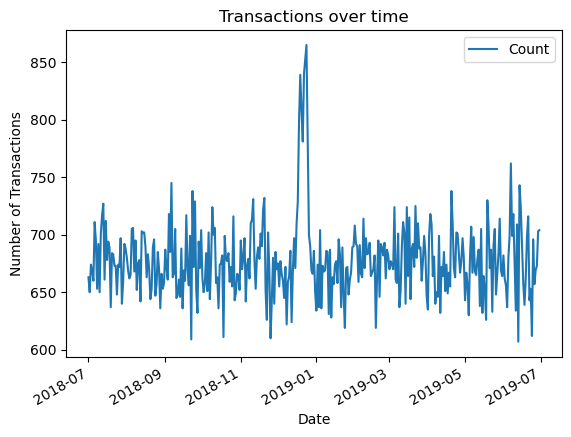

In [62]:
import matplotlib.pyplot as plt
date_counts.plot(x = 'DATE', y = 'Count')
plt.title('Transactions over time')
plt.xlabel('Date')
plt.ylabel('Number of Transactions')
plt.show()

We can see that there is an increase in purchases in December and a break in late
December. Let's zoom in on this.

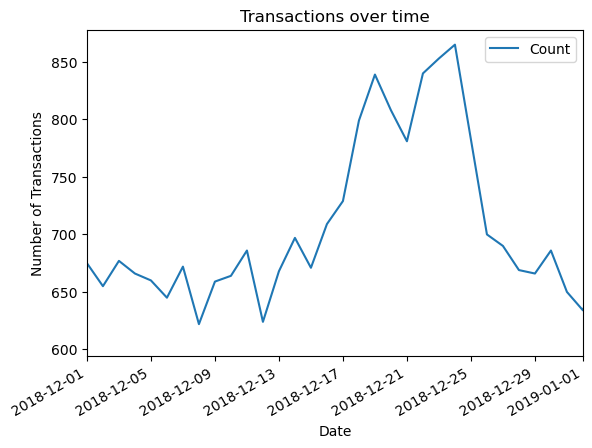

In [63]:
ax = date_counts.plot(x = 'DATE', y = 'Count')
plt.title('Transactions over time')
plt.xlabel('Date')
plt.ylabel('Number of Transactions')
start_date = pd.to_datetime('2018-12-01')
end_date = pd.to_datetime('2019-01-01')
ax.set_xlim(start_date, end_date)
plt.show()

We can see that the increase in sales occurs in the lead-up to Christmas and that
there are zero sales on Christmas day itself. This is due to shops being closed on
Christmas day.
Now that we are satisfied that the data no longer has outliers, we can move on to
creating other features such as brand of chips or pack size from PROD_NAME. We will
start with pack size.

In [64]:
transaction_data_df['PACK_SIZE'] = transaction_data_df['PROD_NAME'].str.extract("(\d+)").astype(int)
transaction_data_df.head(5)

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE
1,2019-05-16,4,4149,3333,16,smiths crinkle chips salt & vinegar 330g,1,5.7,330
2,2019-05-16,4,4196,3539,24,grain waves sweet chilli 210g,1,3.6,210
3,2018-08-20,5,5026,4525,42,doritos corn chip mexican jalapeno 150g,1,3.9,150
4,2019-05-17,7,7215,7176,16,smiths crinkle chips salt & vinegar 330g,1,5.7,330
5,2018-08-17,13,13213,12447,92,ww crinkle cut chicken 175g,1,1.7,175


In [65]:
print('Smallest size: ', transaction_data_df.min(axis=0)['PACK_SIZE'], 'g')
print('Largest size: ', transaction_data_df.max(axis=0)['PACK_SIZE'], 'g')

Smallest size:  70 g
Largest size:  380 g


The largest size is 380g and the smallest size is 70g - seems sensible! Let's plot a histogram of PACK_SIZE since we know that it is a categorical variable and not a continuous variable even though it is numeric.

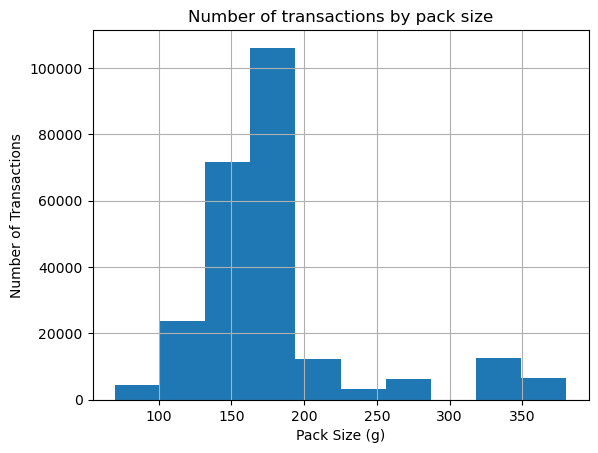

In [66]:
transaction_data_df['PACK_SIZE'].hist()
plt.title('Number of transactions by pack size')
plt.xlabel('Pack Size (g)')
plt.ylabel('Number of Transactions')
plt.show()

Pack sizes created look reasonable.
Now to create brands, we can use the first word in PROD_NAME to work out the brand
name...

In [67]:
transaction_data_df['BRAND'] = transaction_data_df['PROD_NAME'].str.split().str[0]
transaction_data_df.head(5)

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND
1,2019-05-16,4,4149,3333,16,smiths crinkle chips salt & vinegar 330g,1,5.7,330,smiths
2,2019-05-16,4,4196,3539,24,grain waves sweet chilli 210g,1,3.6,210,grain
3,2018-08-20,5,5026,4525,42,doritos corn chip mexican jalapeno 150g,1,3.9,150,doritos
4,2019-05-17,7,7215,7176,16,smiths crinkle chips salt & vinegar 330g,1,5.7,330,smiths
5,2018-08-17,13,13213,12447,92,ww crinkle cut chicken 175g,1,1.7,175,ww


Some of the brand names look like they are of the same brands - such as RED and RRD, which are both Red Rock Deli chips. Let's combine these together.

In [68]:
print(transaction_data_df['BRAND'].unique())

['smiths' 'grain' 'doritos' 'ww' 'thins' 'ccs' 'ncc' 'cheezels' 'infzns'
 'kettle' 'red' 'pringles' 'natural' 'dorito' 'twisties' 'infuzions'
 'smith' 'tyrrells' 'cobs' 'french' 'rrd' 'tostitos' 'woolworths' 'snbts'
 'cheetos' 'sunbites' 'burger' 'grnwves']


Some of the brand names look like they are of the same brands - such as RED and
RRD, which are both Red Rock Deli chips. Let's combine these together.

In [69]:
transaction_data_df = transaction_data_df.replace('rrd', 'red')
transaction_data_df = transaction_data_df.replace('grnwves', 'grain')
transaction_data_df = transaction_data_df.replace('ww', 'woolworths')
transaction_data_df = transaction_data_df.replace('snbts', 'sunbites')
transaction_data_df = transaction_data_df.replace('infzns', 'infuzions')

In [70]:
print(transaction_data_df['BRAND'].unique())

['smiths' 'grain' 'doritos' 'woolworths' 'thins' 'ccs' 'ncc' 'cheezels'
 'infuzions' 'kettle' 'red' 'pringles' 'natural' 'dorito' 'twisties'
 'smith' 'tyrrells' 'cobs' 'french' 'tostitos' 'sunbites' 'cheetos'
 'burger']


Next, let's have a look at the cusotmer data set.

In [75]:
print(purchase_behaviour_df.head(10))
print(purchase_behaviour_df['LIFESTAGE'].unique())
print(purchase_behaviour_df['PREMIUM_CUSTOMER'].unique())

   LYLTY_CARD_NBR               LIFESTAGE PREMIUM_CUSTOMER
0            1000   YOUNG SINGLES/COUPLES          Premium
1            1002   YOUNG SINGLES/COUPLES       Mainstream
2            1003          YOUNG FAMILIES           Budget
3            1004   OLDER SINGLES/COUPLES       Mainstream
4            1005  MIDAGE SINGLES/COUPLES       Mainstream
5            1007   YOUNG SINGLES/COUPLES           Budget
6            1009            NEW FAMILIES          Premium
7            1010   YOUNG SINGLES/COUPLES       Mainstream
8            1011   OLDER SINGLES/COUPLES       Mainstream
9            1012          OLDER FAMILIES       Mainstream
['YOUNG SINGLES/COUPLES' 'YOUNG FAMILIES' 'OLDER SINGLES/COUPLES'
 'MIDAGE SINGLES/COUPLES' 'NEW FAMILIES' 'OLDER FAMILIES' 'RETIREES']
['Premium' 'Mainstream' 'Budget']


Okay so upon initial inspection, this seems reasonable. Let's check for nulls.

In [76]:
purchase_behaviour_df.isnull().values.any()

False

This means there are no null values in this dataframe. Let's make a histogram to see what the distribution
of customer type is.

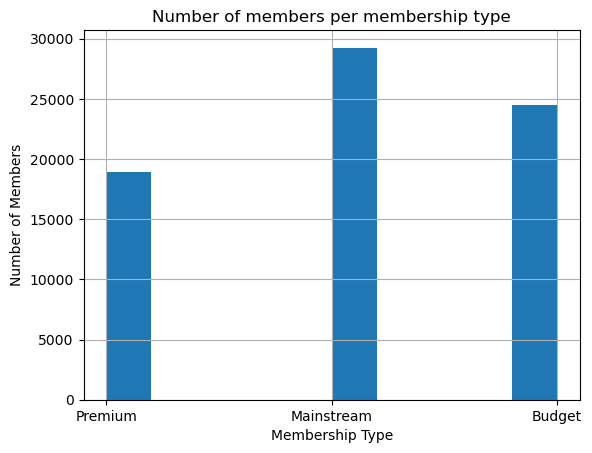

In [78]:
purchase_behaviour_df['PREMIUM_CUSTOMER'].hist()
plt.title('Number of members per membership type')
plt.xlabel('Membership Type')
plt.ylabel('Number of Members')
plt.show()